In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

train_df = pd.read_csv('train.csv')

In [38]:
# Survival distribution

print("Survival count :")
print(train_df['Survived'].value_counts())

Survival count :
Survived
0    549
1    342
Name: count, dtype: int64


In [39]:
# Survival based on gender

print("Survival rate by sex:")
print(train_df.groupby('Sex')['Survived'].mean())

Survival rate by sex:
Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64


In [42]:
# Fill missing values
train_df['Age'].fillna(train_df['Age'].median(), inplace=True)
train_df['Embarked'].fillna(train_df['Embarked'].mode()[0], inplace=True)

test_df['Age'].fillna(test_df['Age'].median(), inplace=True)
test_df['Fare'].fillna(test_df['Fare'].median(), inplace=True)
test_df['Embarked'].fillna(test_df['Embarked'].mode()[0], inplace=True)

# Encode categories
train_df['Sex'] = train_df['Sex'].map({'male': 0, 'female': 1})
train_df['Embarked'] = train_df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
test_df['Sex'] = test_df['Sex'].map({'male': 0, 'female': 1})
test_df['Embarked'] = test_df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})


C:\Users\sshiv\AppData\Local\Temp\ipykernel_19232\1238937020.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['Age'].fillna(train_df['Age'].median(), inplace=True)
C:\Users\sshiv\AppData\Local\Temp\ipykernel_19232\1238937020.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a 

In [43]:
# Features and labels
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
target = 'Survived'

X = train_df[features].values
y = train_df[target].values

X_test = test_df[features].values


In [44]:
# Feature scaling (mean normalization)
def feature_normalize(X):
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    X_norm = (X - mu) / sigma
    return X_norm, mu, sigma

X_norm, mu, sigma = feature_normalize(X)
X_test_norm = (X_test - mu) / sigma


In [45]:
# Featuer Mapping

def linear_features(X):
    return X

def polynomial_features(X, degree=2):
    X_poly = X.copy()
    for i in range(X.shape[1]):
        for d in range(2, degree + 1):
            X_poly = np.hstack((X_poly, (X[:, i] ** d).reshape(-1, 1)))
    return X_poly

X_final = polynomial_features(X_norm, degree=2)
X_test_final = polynomial_features(X_test_norm, degree=2)

In [46]:
# Logistic cost function

def compute_cost(y, probs):
    eps = 1e-15
    probs = np.clip(probs, eps, 1 - eps)
    return -np.mean(y * np.log(probs) + (1 - y) * np.log(1 - probs))

lambdas = [0.01, 0.1, 0.3, 1, 3, 10]
costs = []

for lam in lambdas:
    C_val = 1 / lam
    model = LogisticRegression(C=C_val, max_iter=1000)
    model.fit(X_final, y)
    probs = model.predict_proba(X_final)[:, 1]
    cost = compute_cost(y, probs)
    costs.append(cost)
    print(f"Lambda: {lam:.2f}, Cost: {cost:.4f}")

Lambda: 0.01, Cost: 0.4303
Lambda: 0.10, Cost: 0.4303
Lambda: 0.30, Cost: 0.4303
Lambda: 1.00, Cost: 0.4303
Lambda: 3.00, Cost: 0.4305
Lambda: 10.00, Cost: 0.4318


In [47]:
# Sigmoid and Cost

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_cost(X, y, theta, lam=0):
    m = len(y)
    h = sigmoid(X @ theta)
    h = np.clip(h, 1e-15, 1 - 1e-15)
    cost = (-1/m) * (y.T @ np.log(h) + (1 - y).T @ np.log(1 - h))
    reg = (lam / (2 * m)) * np.sum(theta[1:] ** 2)
    return cost + reg


In [48]:
# Run Gradient Descent

def gradient_descent(X, y, alpha=0.01, lam=0.1, num_iters=500):
    m, n = X.shape
    theta = np.zeros(n)
    cost_history = []

    for i in range(num_iters):
        h = sigmoid(X @ theta)
        error = h - y
        grad = (1/m) * (X.T @ error)
        grad[1:] += (lam/m) * theta[1:]  
        theta -= alpha * grad
        cost = compute_cost(X, y, theta, lam)
        cost_history.append(cost)

    return theta, cost_history


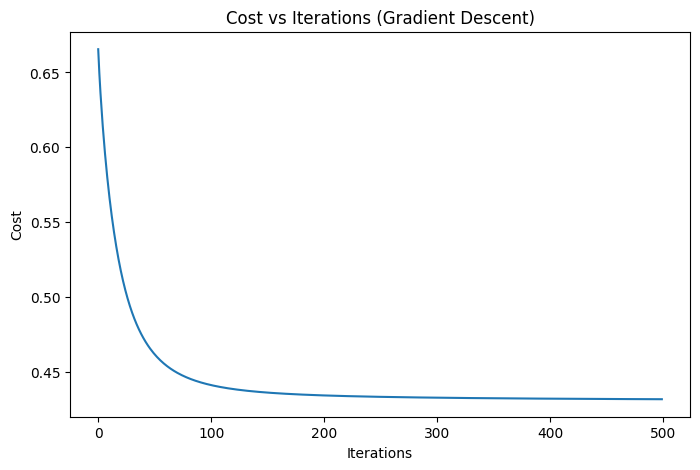

In [49]:
X_gd = np.hstack([np.ones((X_final.shape[0], 1)), X_final])
theta, cost_history = gradient_descent(X_gd, y, alpha=0.1, lam=0.3, num_iters=500)

plt.figure(figsize=(8, 5))
plt.plot(range(len(cost_history)), cost_history)
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.title("Cost vs Iterations (Gradient Descent)")
plt.show()

In [50]:
# --- Manually set passenger features ---

pclass = 3           # 1, 2, or 3
sex = 'female'       # 'male' or 'female'
age = 22.0           # float
sibsp = 1            # int
parch = 0            # int
fare = 7.25          # float
embarked = 'S'       # 'S', 'C', or 'Q'

# --- Preprocess input ---
sex = 0 if sex == 'male' else 1
embarked_map = {'S': 0, 'C': 1, 'Q': 2}
embarked = embarked_map.get(embarked, 0)  # default to 0 if invalid

x_raw = np.array([[pclass, sex, age, sibsp, parch, fare, embarked]])
x_norm = (x_raw - mu) / sigma
x_poly = polynomial_features(x_norm, degree=2)

x_input = np.hstack([np.ones((1, 1)), x_poly])

prob = sigmoid(x_input @ theta)[0]
prediction = 1 if prob >= 0.5 else 0

print(f"Survival Probability: {prob:.4f}")
print(" Prediction:", "Survived" if prediction == 1 else "Did NOT Survive")


Survival Probability: 0.6485
 Prediction: Survived
